In [1]:
from sentence_transformers import SentenceTransformer, util, models, InputExample, losses
from PIL import Image
import glob
import torch
from torch.utils.data import DataLoader
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import pandas as pd
import os
from tqdm.autonotebook import tqdm, trange
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np

In [2]:
import random
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [5]:
models = ['CLIP', 'CLIP16', 'CLIP14', 'CLIP_ML_EN', 'CLIP_ML_NL']
variants = ['O1', 'O2']
trials = ['Baseline', 'fusion', 'new_embedding']
vals = ['val', 'test']
fusions = [('text', 'average'), ('multi', 'concat'), ('image', 'average'), ('multi', 'complex'), ('multi', 'average')]
layers = ['L2', 'L1', 'L0']

In [37]:
results = {}
for model in models:
    with open('model_storage/{}/results_F1.pkl'.format(model), "rb") as fIn:
        results[model] = pickle.load(fIn)

In [38]:
results.keys()

dict_keys(['CLIP', 'CLIP16', 'CLIP14', 'CLIP_ML_EN', 'CLIP_ML_NL'])

In [39]:
[results['CLIP']['new_embedding']['O2']['L2']['val'][i]['macro avg']['f1-score']*100 for i in range(6)]

[78.73390454921682,
 81.253949964514,
 73.79390019237003,
 87.61042878689938,
 71.19908253840646,
 75.29759530791789]

In [41]:
np.array([results['CLIP']['new_embedding']['O2']['L2']['val'][i]['accuracy']*100 for i in range(6)])

array([79.00275773, 81.48663133, 74.12464513, 89.39130435, 71.31423083,
       77.43271222])

## Embedding Settings

### Accuracy

CLIP
[47.27471814 47.09017699 48.24929025 64.69565217 45.22170642 60.66252588]
[61.59258658 61.23229339 62.82276599 71.73913043 61.18136706 68.73706004]
[72.6011842  73.77827989 70.86656753 83.30434783 68.57691692 75.36231884]
[69.31827399 69.83575215 68.67649047 80.86956522 66.43188731 75.98343685]
[79.00275773 81.48663133 74.12464513 89.39130435 71.31423083 77.43271222]
[47.27471814 47.09017699 47.16139497 63.90977444 44.34796337 60.82949309]
[61.59258658 61.23229339 62.04379562 68.89097744 60.89359015 67.05069124]
[72.6011842  73.77827989 68.84293052 80.07518797 66.95610988 69.58525346]
[69.31827399 69.83575215 67.54528251 78.85338346 65.6457215  70.96774194]
[79.00275773 81.48663133 72.28980806 87.59398496 69.71897695 73.2718894 ]
Increased from Initial State
0    0.671142
1    0.730438
2    0.536285
3    0.381720
4    0.576991
5    0.276451
0    0.671142
1    0.730438
2    0.532817
3    0.370588
4    0.572090
5    0.204545
dtype: float64
Increased with Enhancing
0    0.139710
1   

<Figure size 2400x500 with 0 Axes>

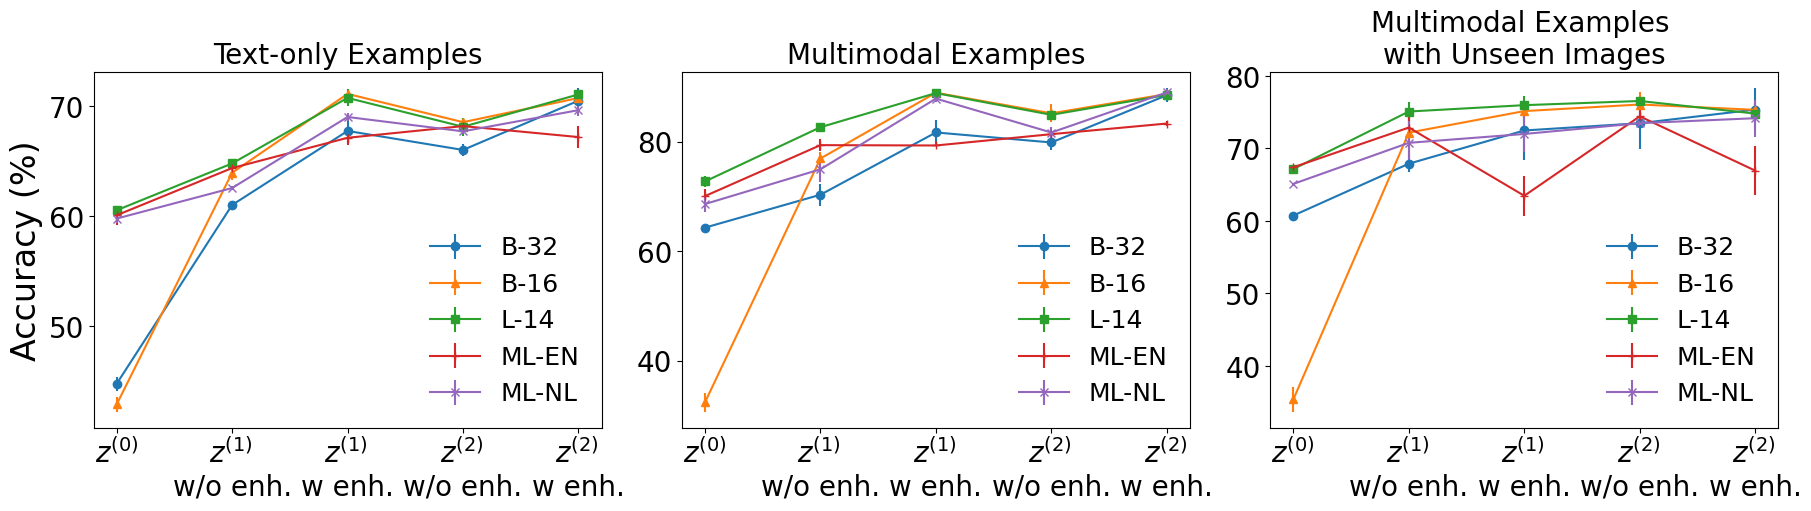

In [85]:
emb_increased = []
emb_increased_enh = []
markers = ['o', '^', 's', '+', 'x']
titles = ['Multimodal Examples', 'Text-only Examples', 'Multimodal Examples \nwith Unseen Images']
model_names = ['B-32', 'B-16', 'L-14', 'ML-EN', 'ML-NL']
plt.figure(figsize=(24,5))
fig, axes = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=False, layout="constrained")

for i in range(len(models)):
    df = pd.DataFrame()
    model = models[i]
    print(model)
    for vs in ['val', 'test']:
        perf = []
        for o in ['O1', 'O2']:
            for l in ['L0', 'L1', 'L2']:
                if not (o=='O2' and l=='L0'):
                    temp = np.array([results[model]['new_embedding'][o][l][vs][i]['accuracy']*100 for i in range(6)]).astype(float)
                    print(temp)
                    perf.append(temp)
        
        df_t = pd.DataFrame(perf)
        df_t['name'] = pd.Series(['$z^{(0)}$', '$z^{(1)}$ \nw/o enh.', '$z^{(1)}$ \nw enh.', '$z^{(2)}$ \nw/o enh.', '$z^{(2)}$ \nw enh.'])
        df_t = df_t.set_index('name')
        
        df = pd.concat([df, df_t], axis=1)
        

    for j in range(3):
        j0 = [2,1,3][j]
        if j==1:
            ax.set_ylabel('Accuracy (%)', size=24)
        ax = axes.reshape(-1)[j]
        ax.errorbar(np.arange(5), df[j0+2].mean(axis=1), yerr = df[j0+2].std(axis=1), label=model_names[i], marker=markers[i])
        ax.set_title(titles[j0-1], size=20)
    
    print('Increased from Initial State')
    inc1 = (df.iloc[4] - df.iloc[0])/df.iloc[0]
    print(inc1)
    emb_increased.append(inc1)
    print('Increased with Enhancing')
    inc2 = (df.iloc[4] -df.iloc[3])/df.iloc[3]
    print(inc2)
    emb_increased_enh.append(inc2)
    emb_increased_enh.append((df.iloc[2] -df.iloc[1])/df.iloc[1])
    print()

    for ax in axes.reshape(-1):
        ax.legend(frameon=False, fontsize=18)
        plt.xticks(range(0, len(list(df.index))), list(df.index))
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

In [68]:
emb_increased = []
emb_increased_enh = []
initial = []
end = []
w_enh = []
wo_enh = []
model_names = ['B-32', 'B-16', 'L-14', 'ML-EN', 'ML-NL']

for i in range(len(models)):
    df = pd.DataFrame()
    model = models[i]
    print(model)
    for vs in ['val', 'test']:
        perf = []
        for o in ['O1', 'O2']:
            for l in ['L0', 'L1', 'L2']:
                if not (o=='O2' and l=='L0'):
                    temp = temp = np.array([results[model]['new_embedding'][o][l][vs][i]['accuracy']*100 for i in range(6)]).astype(float)
                    perf.append(temp)
        
        df_t = pd.DataFrame(perf)
        df_t['name'] = pd.Series(['$z^{(0)}$', '$z^{(1)}$ \nw/o enh.', '$z^{(1)}$ \nw enh.', '$z^{(2)}$ \nw/o enh.', '$z^{(2)}$ \nw enh.'])
        df_t = df_t.set_index('name')
        
        df = pd.concat([df, df_t], axis=1)
        

    initial.append(df.iloc[0])
    end.append(df.iloc[4])
    w_enh.append(df.iloc[4])
    w_enh.append(df.iloc[2])
    wo_enh.append(df.iloc[3])
    wo_enh.append(df.iloc[1])
        
    inc1 = (df.iloc[4] - df.iloc[0])/df.iloc[0]
    emb_increased.append(inc1)
    inc2 = (df.iloc[4] -df.iloc[3])/df.iloc[3]
    emb_increased_enh.append(inc2)
    emb_increased_enh.append((df.iloc[2] -df.iloc[1])/df.iloc[1])
    print()

CLIP

CLIP16

CLIP14

CLIP_ML_EN

CLIP_ML_NL



In [52]:
import pingouin as pg

C:\Users\Nan\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Initial-state Accuracy

In [86]:
a=np.hstack([np.vstack(initial)[:,3], np.vstack(initial)[:,9]])
a.mean(), a.std()

(61.62170644001308, 14.896759613957833)

End-state Accuracy

In [87]:
b=np.hstack([np.vstack(end)[:,3], np.vstack(end)[:,9]])
b.mean(), b.std()

(87.61113108859104, 2.2081265558816425)

In [88]:
pg.ttest(b,a, alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.17734,18,greater,0.000032,"[17.28, inf]",2.315377,579.832,0.999561


General Increase

In [89]:
a=np.hstack([np.vstack(initial)[:,3:6], np.vstack(initial)[:,9:]])
a.mean(), a.std()

(58.13846038474958, 12.476954330595674)

In [90]:
b=np.hstack([np.vstack(end)[:,3:6], np.vstack(end)[:,9:]])
b.mean(), b.std()

(76.92382166654268, 8.115981513997774)

In [91]:
pg.ttest(b.reshape(-1),a.reshape(-1), alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.796558,58,greater,3.216291e-09,"[14.17, inf]",1.754864,2.761e+06,1.0


General with Enhancing

In [92]:
c = np.hstack([np.vstack(w_enh)[:,3:6], np.vstack(w_enh)[:,9:]])
c.mean(), c.std()

(76.18198383730967, 8.103356717472733)

General without Enhancing

In [93]:
d = np.hstack([np.vstack(wo_enh)[:,3:6], np.vstack(wo_enh)[:,9:]])
d.mean(), d.std()

(72.84982201729255, 6.714747443112784)

In [95]:
pg.ttest(c.reshape(-1),d.reshape(-1), alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.432069,118,greater,0.008258,"[1.06, inf]",0.444033,5.42,0.780308


### Macro-Average F1

CLIP
[45.53333107 45.27565347 46.78013985 61.44330374 41.56358147 58.71126228]
[53.69286817 53.33668628 55.15302131 48.66487469 55.16736946 49.10076838]
[71.27038579 72.58122756 69.34883438 76.46306364 67.70580043 66.34619326]
[67.78617274 68.38702182 67.01108966 73.4476867  65.44831232 69.32728945]
[78.73390455 81.25394996 73.79390019 87.61042879 71.19908254 75.29759531]
[45.53333107 45.27565347 45.46979645 61.01359165 40.59016218 58.53938141]
[53.69286817 53.33668628 53.89621411 46.8699038  54.17696306 48.82539683]
[71.27038579 72.58122756 66.98496636 72.95282861 65.70669754 58.54103343]
[67.78617274 68.38702182 65.72924721 72.25103885 64.40185238 64.08417402]
[78.73390455 81.25394996 71.90302236 86.03007878 69.51981729 70.97860173]
Increased from Initial State
0    0.729149
1    0.794650
2    0.577462
3    0.425874
4    0.713016
5    0.282507
0    0.729149
1    0.794650
2    0.581336
3    0.410015
4    0.712726
5    0.212493
dtype: float64
Increased with Enhancing
0    0.161504
1   

<Figure size 2000x600 with 0 Axes>

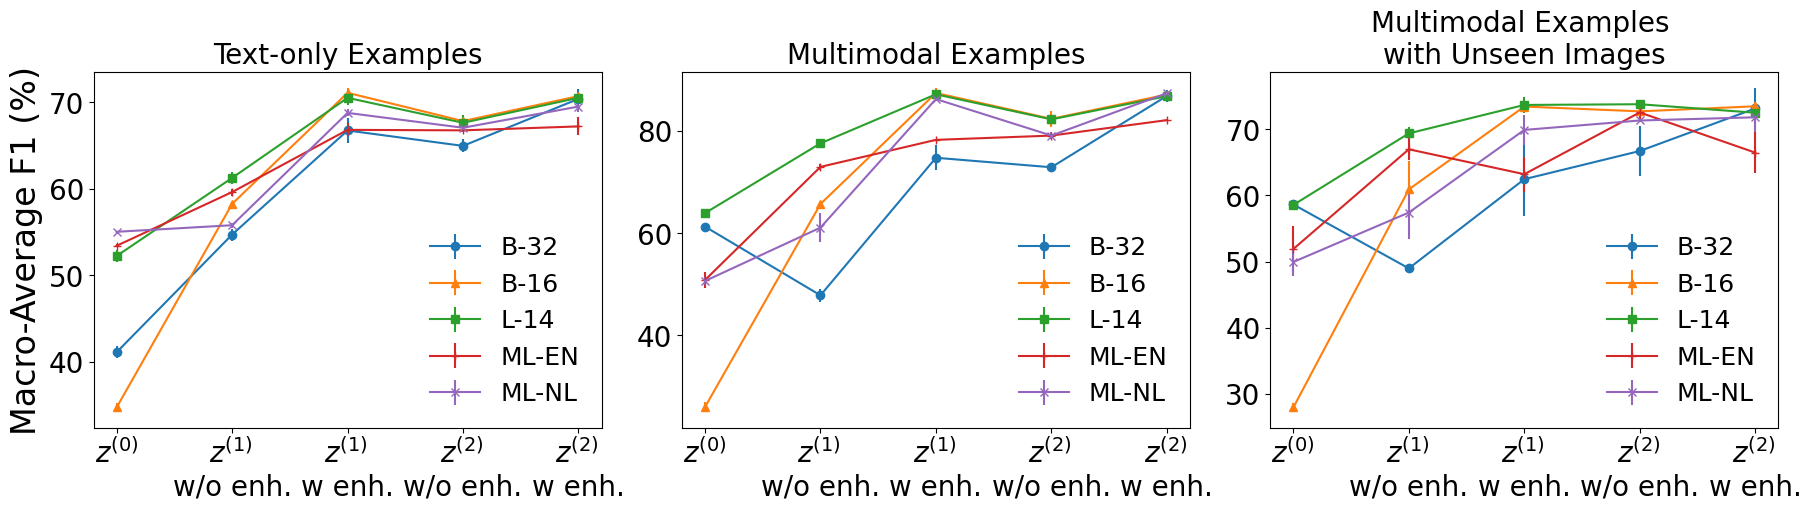

In [139]:
emb_increased = []
emb_increased_enh = []
markers = ['o', '^', 's', '+', 'x']
titles = ['Multimodal Examples', 'Text-only Examples', 'Multimodal Examples \nwith Unseen Images']
model_names = ['B-32', 'B-16', 'L-14', 'ML-EN', 'ML-NL']
plt.figure(figsize=(20,6))
fig, axes = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=False, layout="constrained")

for i in range(len(models)):
    df = pd.DataFrame()
    model = models[i]
    print(model)
    for vs in ['val', 'test']:
        perf = []
        for o in ['O1', 'O2']:
            for l in ['L0', 'L1', 'L2']:
                if not (o=='O2' and l=='L0'):
                    temp = np.array([results[model]['new_embedding'][o][l][vs][i]['macro avg']['f1-score']*100 for i in range(6)]).astype(float)
                    print(temp)
                    perf.append(temp)
        
        df_t = pd.DataFrame(perf)
        df_t['name'] = pd.Series(['$z^{(0)}$', '$z^{(1)}$ \nw/o enh.', '$z^{(1)}$ \nw enh.', '$z^{(2)}$ \nw/o enh.', '$z^{(2)}$ \nw enh.'])
        df_t = df_t.set_index('name')
        
        df = pd.concat([df, df_t], axis=1)
        

    for j in range(3):
        j0 = [2,1,3][j]
        if j==1:
            ax.set_ylabel('Macro-Average F1 (%)', size=24)
        ax = axes.reshape(-1)[j]
        ax.errorbar(np.arange(5), df[j0+2].mean(axis=1), yerr = df[j0+2].std(axis=1), label=model_names[i], marker=markers[i])
        ax.set_title(titles[j0-1], size=20)
    
    print('Increased from Initial State')
    inc1 = (df.iloc[4] - df.iloc[0])/df.iloc[0]
    print(inc1)
    emb_increased.append(inc1)
    print('Increased with Enhancing')
    inc2 = (df.iloc[4] -df.iloc[3])/df.iloc[3]
    print(inc2)
    emb_increased_enh.append(inc2)
    emb_increased_enh.append((df.iloc[2] -df.iloc[1])/df.iloc[1])
    print()

    for ax in axes.reshape(-1):
        ax.legend(frameon=False, fontsize=18)
        plt.xticks(range(0, len(list(df.index))), list(df.index))
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

In [96]:
emb_increased = []
emb_increased_enh = []
initial = []
end = []
w_enh = []
wo_enh = []
model_names = ['B-32', 'B-16', 'L-14', 'ML-EN', 'ML-NL']

for i in range(len(models)):
    df = pd.DataFrame()
    model = models[i]
    print(model)
    for vs in ['val', 'test']:
        perf = []
        for o in ['O1', 'O2']:
            for l in ['L0', 'L1', 'L2']:
                if not (o=='O2' and l=='L0'):
                    temp = np.array([results[model]['new_embedding'][o][l][vs][i]['macro avg']['f1-score']*100 for i in range(6)]).astype(float)
                    perf.append(temp)
        
        df_t = pd.DataFrame(perf)
        df_t['name'] = pd.Series(['$z^{(0)}$', '$z^{(1)}$ \nw/o enh.', '$z^{(1)}$ \nw enh.', '$z^{(2)}$ \nw/o enh.', '$z^{(2)}$ \nw enh.'])
        df_t = df_t.set_index('name')
        
        df = pd.concat([df, df_t], axis=1)
        

    initial.append(df.iloc[0])
    end.append(df.iloc[4])
    w_enh.append(df.iloc[4])
    w_enh.append(df.iloc[2])
    wo_enh.append(df.iloc[3])
    wo_enh.append(df.iloc[1])
        
    inc1 = (df.iloc[4] - df.iloc[0])/df.iloc[0]
    emb_increased.append(inc1)
    inc2 = (df.iloc[4] -df.iloc[3])/df.iloc[3]
    emb_increased_enh.append(inc2)
    emb_increased_enh.append((df.iloc[2] -df.iloc[1])/df.iloc[1])
    print()

CLIP

CLIP16

CLIP14

CLIP_ML_EN

CLIP_ML_NL



Initial-state F1

In [97]:
a=np.hstack([np.vstack(initial)[:,3], np.vstack(initial)[:,9]])
a.mean(), a.std()

(50.4639925941091, 13.430205712672011)

End-state F1

In [98]:
b=np.hstack([np.vstack(end)[:,3], np.vstack(end)[:,9]])
b.mean(), b.std()

(86.02531903393519, 2.0297887434474684)

In [99]:
pg.ttest(b,a, alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.854386,18,greater,1.590185e-07,"[27.71, inf]",3.512588,5.998e+04,1.0


General Increase

In [100]:
a=np.hstack([np.vstack(initial)[:,3:6], np.vstack(initial)[:,9:]])
a.mean(), a.std()

(49.04024233003128, 11.230009393751487)

In [101]:
b=np.hstack([np.vstack(end)[:,3:6], np.vstack(end)[:,9:]])
b.mean(), b.std()

(75.71026884689222, 7.669468017185499)

In [102]:
pg.ttest(b.reshape(-1),a.reshape(-1), alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.561224,58,greater,1.972953e-15,"[22.45, inf]",2.726896,2.108e+12,1.0


General with Enhancing

In [103]:
c = np.hstack([np.vstack(w_enh)[:,3:6], np.vstack(w_enh)[:,9:]])
c.mean(), c.std()

(74.52370706389232, 7.930484446248677)

General without Enhancing

In [104]:
d = np.hstack([np.vstack(wo_enh)[:,3:6], np.vstack(wo_enh)[:,9:]])
d.mean(), d.std()

(66.8190129687635, 8.979092033152554)

In [105]:
pg.ttest(c.reshape(-1),d.reshape(-1), alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.940037,118,greater,0.000001,"[5.12, inf]",0.901923,1.172e+04,0.999456


## Golden Label Classification

In [111]:
def compute_loss(v):
    return torch.sum(-torch.tensor([[1,0],[0,1]]) * torch.log(torch.tensor(results[model]['fusion'][v][fusion]['golden'].astype(float)))).numpy()

final = np.zeros((5,5,3))
for i in range(len(models)):
    model = models[i]
    print(model)
    
    for j in range(len(fusions)):
        fusion = fusions[j]
        print(fusion)
        a = compute_loss('O1')
        b = compute_loss('O2')
        print(a)
        print(b)
        
        final[i,j,0] = a
        final[i,j,1] = b
        final[i,j,2] = a-b
    print()

CLIP
('text', 'average')
1.2317545079271426
0.7600832058006055
('multi', 'concat')
1.1321278149153904
0.8861297725892493
('image', 'average')
1.407957089299063
1.408476932430311
('multi', 'complex')
1.1960184030587984
0.18447486403096744
('multi', 'average')
1.1782944132555244
0.9683899025715162

CLIP16
('text', 'average')
1.0560397080055708
0.7054406654808305
('multi', 'concat')
1.0242578295400535
0.7197688786823239
('image', 'average')
1.4122116371439248
1.4015418072567352
('multi', 'complex')
0.9915765387181359
0.3279774978255077
('multi', 'average')
1.119238747460742
0.9357450065041587

CLIP14
('text', 'average')
0.748399635164356
0.3025248251045962
('multi', 'concat')
0.7225013335620404
0.2921723953013559
('image', 'average')
1.4034358294429647
1.4004157973769034
('multi', 'complex')
0.7116202529394824
0.07417752294542605
('multi', 'average')
0.706025604419693
0.4520456490485334

CLIP_ML_EN
('text', 'average')
1.1902366704534295
0.7696364234106211
('multi', 'concat')
1.18533494750

In [116]:
final.transpose(1,0,2)[:,:,0].mean(), final.transpose(1,0,2)[:,:,0].std()

(1.1068110223490077, 0.2180463234757931)

In [117]:
final.transpose(1,0,2)[:,:,1].mean(), final.transpose(1,0,2)[:,:,1].std()

(0.7731142152033912, 0.4070683838486944)

In [118]:
pg.ttest(final.transpose(1,0,2)[:,:,0].reshape(-1), final.transpose(1,0,2)[:,:,1].reshape(-1), alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.54009,48,greater,0.00045,"[0.18, inf]",1.001289,67.958,0.967458


## Fusion Performance

In [120]:
fusions

[('text', 'average'),
 ('multi', 'concat'),
 ('image', 'average'),
 ('multi', 'complex'),
 ('multi', 'average')]

In [121]:
fusions_new = [('image', 'average'), ('text', 'average'), ('multi', 'average'), ('multi', 'concat'), ('multi', 'complex')]

In [126]:
[results['CLIP']['fusion']['O1'][('text', 'average')]['performance']['val'][i]['accuracy']*100 for i in range(6)]

[72.93981669235137,
 73.38721358013962,
 72.4212518588617,
 83.04347826086956,
 70.46582359532576,
 77.84679089026915]

### Accuracy

In [127]:
perf = {}
perf_enh = {}

for fusion in fusions_new:
    print(fusion)
    perf[fusion] = []
    perf_enh[fusion] = []
    
    for model in models:
        print(model)
        
        for vs in ['val', 'test']:
            a = np.array([results[model]['fusion']['O1'][fusion]['performance'][vs][i]['accuracy']*100 for i in range(6)]).astype(float)
            b = np.array([results[model]['fusion']['O2'][fusion]['performance'][vs][i]['accuracy']*100 for i in range(6)]).astype(float)
            print(a)
            perf[fusion].append(a)
            print(b)
            perf_enh[fusion].append(b)
        
            print('Increased with Enhancing')
            print((a-b)/b)
    print()

('image', 'average')
CLIP
[62.33879471 62.47211842 61.80884142 85.04347826 57.53161518 74.12008282]
[62.35704437 62.49529272 61.83587941 85.2173913  57.53161518 74.53416149]
Increased with Enhancing
[-0.00029266 -0.00037082 -0.00043725 -0.00204082  0.         -0.00555556]
[62.33879471 62.47211842 62.24655312 82.51879699 58.84117461 70.2764977 ]
[62.35704437 62.49529272 62.23303596 82.42481203 58.84117461 69.35483871]
Increased with Enhancing
[-0.00029266 -0.00037082  0.0002172   0.00114025  0.          0.01328904]
CLIP16
[62.32054506 62.44894412 61.60605651 83.73913043 57.53161518 73.08488613]
[62.23943548 62.34755656 61.6330945  83.91304348 57.53161518 73.91304348]
Increased with Enhancing
[ 0.00130319  0.00162617 -0.00043869 -0.00207254  0.         -0.01120448]
[62.32054506 62.44894412 62.43579346 83.83458647 58.84117461 71.65898618]
[62.23943548 62.34755656 62.34117329 83.17669173 58.84117461 72.11981567]
Increased with Enhancing
[ 0.00130319  0.00162617  0.00151778  0.0079096   0. 

In [128]:
data_a = np.vstack([np.vstack(value)[:,2] for key,value in perf.items()]).tolist()
data_a

[[61.80884142219819,
  62.24655312246553,
  61.6060565093957,
  62.43579345769127,
  62.0251453291875,
  62.62503379291701,
  61.80884142219819,
  62.273587456069215,
  61.80884142219819,
  62.24655312246553],
 [72.4212518588617,
  71.37064071370641,
  73.27294849263215,
  72.27629088942957,
  73.05664458564283,
  72.6007028926737,
  71.56955522509125,
  70.95160854284941,
  70.70433959713397,
  70.66774804001082],
 [72.00216303906988,
  71.19491754528251,
  72.5429228065432,
  71.87077588537443,
  72.75922671353251,
  72.3573938902406,
  70.47451669595782,
  69.80264936469315,
  70.65026362038664,
  69.9918896999189],
 [73.08368257401649,
  71.64098404974317,
  73.38110044612681,
  72.49256555825899,
  73.47573340543464,
  72.81697756150311,
  72.63755576585102,
  71.62746688294133,
  71.55603623090443,
  71.41119221411192],
 [74.31391104501826,
  72.58718572587186,
  74.65188589968906,
  73.95241957285754,
  74.24631607408408,
  73.2360097323601,
  73.88130323103961,
  72.15463638821

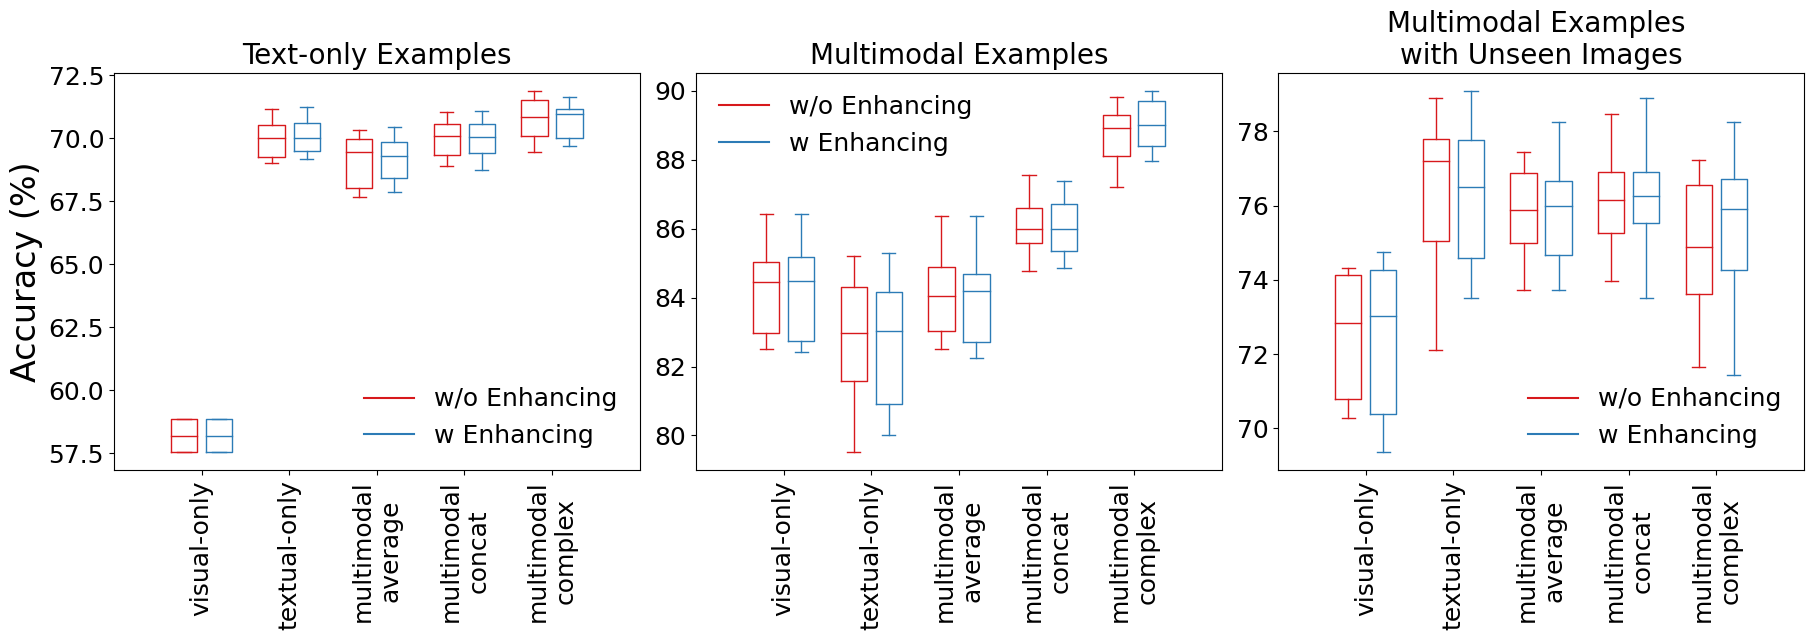

In [134]:
fs = ['visual-only', 'textual-only', 'multimodal\naverage', 'multimodal\nconcat', 'multimodal\ncomplex']
titles = ['Multimodal Examples', 'Text-only Examples', 'Multimodal Examples \nwith Unseen Images']
ticks = fs

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig, axes = plt.subplots(1,3, figsize=(18,6.5), sharex=True, sharey=False, layout="tight")

for i in range(len(axes.reshape(-1))):

    i0 = [1,0,2][i]
    ax = axes.reshape(-1)[i]
    if i==0:
        ax.set_ylabel('Accuracy (%)', size=24)
    data_a = np.vstack([np.vstack(value)[:,i0+3] for key,value in perf.items()]).tolist()
    data_b = np.vstack([np.vstack(value)[:,i0+3] for key,value in perf_enh.items()]).tolist()

    bpl = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    bpr = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    ax.set_title(titles[i0], size=20)

    # draw temporary red and blue lines and use them to create a legend
    ax.plot([], c='#D7191C', label='w/o Enhancing')
    ax.plot([], c='#2C7BB6', label='w Enhancing')
    ax.legend(frameon=False, fontsize=18)
    
    ax.tick_params(axis='x', labelsize=18, rotation=90)
    ax.tick_params(axis='y', labelsize=18)

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('boxcompare.png')

### Macro-Average F1

In [141]:
perf = {}
perf_enh = {}

for fusion in fusions_new:
    print(fusion)
    perf[fusion] = []
    perf_enh[fusion] = []
    
    for model in models:
        print(model)
        
        for vs in ['val', 'test']:
            a = np.array([results[model]['fusion']['O1'][fusion]['performance'][vs][i]['macro avg']['f1-score']*100 for i in range(6)]).astype(float)
            b = np.array([results[model]['fusion']['O2'][fusion]['performance'][vs][i]['macro avg']['f1-score']*100 for i in range(6)]).astype(float)
            print(a)
            perf[fusion].append(a)
            print(b)
            perf_enh[fusion].append(b)
        
            print('Increased with Enhancing')
            print((a-b)/b)
    print()

('image', 'average')
CLIP
[45.71780086 46.06965337 44.89604387 81.48779018 36.52067879 69.49910329]
[45.95861922 46.31446973 45.1244472  81.97086566 36.52067879 70.63510501]
Increased with Enhancing
[-0.0052399  -0.00528596 -0.00506163 -0.00589326  0.         -0.01608268]
[45.71780086 46.06965337 44.87469851 79.18158675 37.04403141 65.53329024]
[45.95861922 46.31446973 45.10974592 79.44696205 37.04403141 65.50429986]
Increased with Enhancing
[-0.0052399  -0.00528596 -0.00521057 -0.00334028  0.          0.00044257]
CLIP16
[45.62638084 46.01651639 44.35023262 79.45791045 36.52067879 67.58188427]
[45.54111201 45.89313305 44.48624588 79.83815559 36.52067879 68.95633544]
Increased with Enhancing
[ 0.00187235  0.00268849 -0.00305742 -0.0047627   0.         -0.0199322 ]
[45.62638084 46.01651639 45.05351559 80.60821837 37.04403141 67.00476553]
[45.54111201 45.89313305 44.92735887 79.8375409  37.04403141 67.79763912]
Increased with Enhancing
[ 0.00187235  0.00268849  0.00280802  0.00965307  0. 

In [142]:
data_a = np.vstack([np.vstack(value)[:,2] for key,value in perf.items()]).tolist()
data_a

[[44.89604386687888,
  44.87469851328582,
  44.350232617970995,
  45.05351558563107,
  45.208137069756724,
  45.427333114656385,
  44.89604386687888,
  44.93856908298469,
  44.89604386687888,
  44.87469851328582],
 [71.74906046625317,
  70.58104678317119,
  72.32929987260275,
  71.19867733287413,
  72.38928154567661,
  71.85905803225539,
  70.67490512305797,
  69.87109306443197,
  69.43748188309877,
  69.30278951654483],
 [71.05803770298729,
  70.10752266949602,
  71.59395175116788,
  70.79635819618409,
  71.69854885556315,
  71.18704756667941,
  70.30977426894445,
  69.5792303877335,
  69.34205026362223,
  68.59922482517268],
 [72.5387477812028,
  71.0140576461725,
  72.59344125867871,
  71.60634078339515,
  72.61824279960986,
  71.87342345015526,
  71.51089569431804,
  70.21506228349152,
  70.87267685683015,
  70.61870017750157],
 [73.71890336078198,
  71.89866760168304,
  74.01279246552123,
  73.28538351332756,
  73.50906333224879,
  72.35041308536157,
  73.17895455944507,
  71.2561

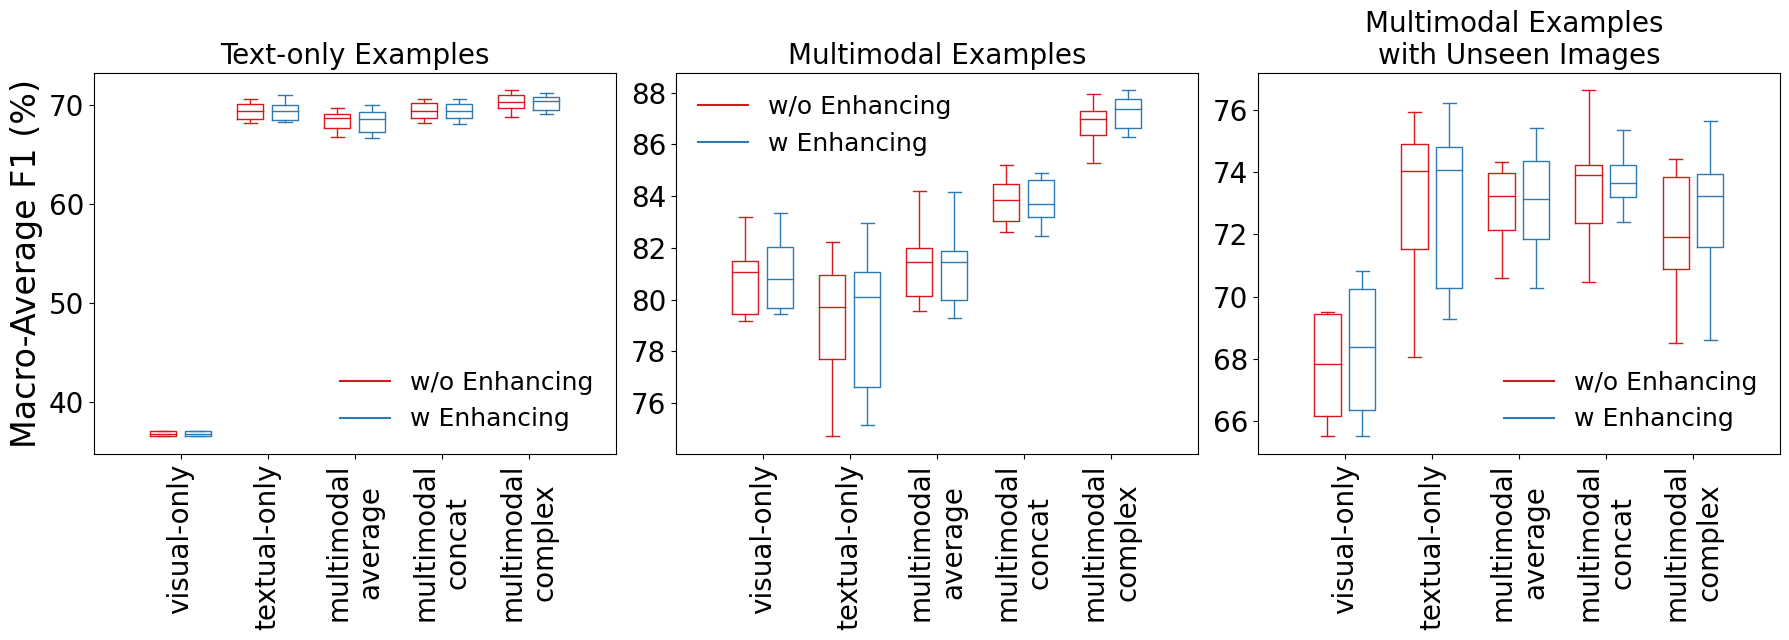

In [150]:
fs = ['visual-only', 'textual-only', 'multimodal\naverage', 'multimodal\nconcat', 'multimodal\ncomplex']
titles = ['Multimodal Examples', 'Text-only Examples', 'Multimodal Examples \nwith Unseen Images']
ticks = fs
from matplotlib.ticker import MaxNLocator

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig, axes = plt.subplots(1,3, figsize=(18,6.5), sharex=True, sharey=False, layout="tight")

for i in range(len(axes.reshape(-1))):

    i0 = [1,0,2][i]
    ax = axes.reshape(-1)[i]
    if i==0:
        ax.set_ylabel('Macro-Average F1 (%)', size=24)
    data_a = np.vstack([np.vstack(value)[:,i0+3] for key,value in perf.items()]).tolist()
    data_b = np.vstack([np.vstack(value)[:,i0+3] for key,value in perf_enh.items()]).tolist()

    bpl = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    bpr = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    ax.set_title(titles[i0], size=20)

    # draw temporary red and blue lines and use them to create a legend
    ax.plot([], c='#D7191C', label='w/o Enhancing')
    ax.plot([], c='#2C7BB6', label='w Enhancing')
    ax.legend(frameon=False, fontsize=18)
    
    ax.tick_params(axis='x', labelsize=20, rotation=90)
    ax.tick_params(axis='y', labelsize=20)
    if not i==0:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('boxcompare.png')